In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
!pip install transformers

In [ ]:
df_train = pd.read_table("/content/train.tsv")
df_test = pd.read_table("/content/test.tsv")
sample_sub = pd.read_csv("/content/sampleSubmission.csv")

In [ ]:
import json

def boilerplate_pre(data):
    '''
    This will only take body of the article; if there is no body than we'll take the title 
    '''
    jsonData = json.loads(data)

    try:
        x = jsonData["body"]
        x = ' '.join(x.split(' ')[-400:])
    except:
        x = jsonData["title"]
    return x

In [ ]:
# applies above func and stores result in a new column
df_train['main'] = df_train.boilerplate.map(boilerplate_pre)
df_train = df_train.dropna()
df_test['main'] = df_test.boilerplate.map(boilerplate_pre)

In [ ]:
df_train.drop("boilerplate",axis = 1, inplace=True)
df_test.drop("boilerplate", axis = 1, inplace= True)

In [ ]:
df_train.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label,main
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,0.443783,0.0,0,0.090774,0,0.245831,0.003883,1,1,24,0,5424,170,8,0.152941,0.079130,0,themselves Traffic Predictors IBM also sees da...
1,http://www.popsci.com/technology/article/2012-...,8471,recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,0.468649,0.0,0,0.098707,0,0.203490,0.088652,1,1,40,0,4973,187,9,0.181818,0.125448,1,games it s clearly electronic but still more t...
2,http://www.menshealth.com/health/flu-fighting-...,1164,health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,0.525448,0.0,0,0.072448,0,0.226402,0.120536,1,1,55,0,2240,258,11,0.166667,0.057613,1,Apples The most popular source of antioxidants...
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,0.480725,0.0,0,0.095861,0,0.265656,0.035343,1,0,24,0,2737,120,5,0.041667,0.100858,1,to follow regularly Don t worry about not gett...
4,http://bleacherreport.com/articles/1205138-the...,9006,sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,0.446143,0.0,0,0.024908,0,0.228887,0.050473,1,1,14,0,12032,162,10,0.098765,0.082569,0,simultaneously poking at greatness and insanit...


In [ ]:
df_test.head()

,url,urlid,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,framebased,frameTagRatio,hasDomainLink,html_ratio,image_ratio,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,main
0,http://www.lynnskitchenadventures.com/2009/04/...,5865,recreation,0.443906,2.558140,0.389706,0.257353,0.044118,0.022059,0.489572,0.0,0,0.067143,0,0.230285,0.199438,1,1,15,0,5643,136,3,0.242647,0.080597,I usually buy my enchilada sauce Yes I knew I ...
1,http://lolpics.se/18552-stun-grenade-ar,782,culture_politics,0.135844,3.771429,0.461538,0.205128,0.051282,0.000000,0.782051,0.0,0,0.042857,0,0.365962,0.080000,?,1,62,0,382,39,2,0.128205,0.176471,funny pictures at lolpics.se. the best funny ...
2,http://www.xcelerationfitness.com/treadmills.html,6962,?,?,2.269565,0.495726,0.384615,0.170940,0.170940,1.250000,0.0,0,0.058824,0,0.161901,10.000000,?,1,42,0,2420,117,1,0.581197,0.125000,"treadmills, stair, climbers, treadmills"
3,http://www.bloomberg.com/news/2012-02-06/syria...,7640,culture_politics,0.90259,2.523490,0.705502,0.346278,0.122977,0.090615,0.449366,0.0,0,0.058081,0,0.146593,0.005964,1,1,41,0,5559,309,10,0.038835,0.063126,twice the average of 34 in 2011 according to t...
4,http://www.wired.com/gadgetlab/2011/12/stem-tu...,3589,science_technology,0.486363,1.848000,0.470968,0.161290,0.032258,0.000000,0.453757,0.0,0,0.093023,0,0.244141,0.035714,1,0,34,0,2209,155,10,0.096774,0.065341,Quirky s Stem turns any citrus fruit into an a...


405


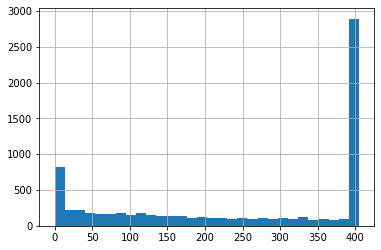

In [ ]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in df_train.main]

pd.Series(seq_len).hist(bins = 30)
print(max(seq_len))

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(df_train.main.values, df_train.label.values, test_size=0.1, random_state=42, stratify=df_train.label.values)

In [ ]:
y_train

array([0, 1, 0, ..., 1, 0, 1])

In [ ]:
from transformers import AdamW
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig

In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased",  do_lower_case=True)

In [ ]:
train_token = tokenizer.batch_encode_plus(
    list(x_train),
    add_special_tokens=True,
    return_attention_mask = True,
    padding = "max_length",
    max_length = 405,
    return_tensors = "pt",
    truncation = True
)

valid_token = tokenizer.batch_encode_plus(
    list(x_val),
    add_special_tokens=True,
    return_attention_mask = True,
    padding = "max_length",
    max_length = 405,
    return_tensors = "pt",
    truncation = True
)

In [ ]:
# sample data
text = ["Bert tokenizer example","let's see how it works"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 14324, 19204, 17629, 2742, 102, 0, 0, 0], [101, 2292, 1005, 1055, 2156, 2129, 2009, 2573, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [ ]:
len(train_token)

3

In [ ]:
batch = 8

input_ids_train = train_token['input_ids']
attention_masks_train = train_token['attention_mask']
labels_train = torch.tensor(list(y_train))#.float()

input_ids_val = valid_token['input_ids']
attention_masks_val = valid_token['attention_mask']
labels_val = torch.tensor(list(y_val))#.float()

# making dataset
dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

# making dataloader
train_loader = DataLoader(dataset_train, sampler=RandomSampler(dataset_train), batch_size=batch)
valid_loader = DataLoader(dataset_val, sampler=SequentialSampler(dataset_val), batch_size=batch)

In [ ]:
from transformers import BertForSequenceClassification

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",output_hidden_states = False,
                                                      output_attentions = False, num_labels=2)
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
FULL_FINETUNING = True
if FULL_FINETUNING:
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params' : [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate' : 0.01},
         {'params' : [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
          'weight_decay_rate':0.0}
    ]
else:
    param_optimizer = list(model.classifier.named_parameters())
    optimizer_grouped_parameters = [{"params": [p for n,p in param_optimizer]}]

optimizer = AdamW(
    optimizer_grouped_parameters,
    lr = 3e-5,
    eps = 1e-8
)

In [ ]:
from transformers import get_linear_schedule_with_warmup

epochs = 5
max_grad_norm = 1.0

# Total number of training steps is number of batches * number of epochs
total_steps = len(train_loader) * epochs

# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps = 0,
    num_training_steps = total_steps
)

In [ ]:
train_losses = []
validation_losses = []

for epoch in range(1, epochs+1):
    train_loss = 0.0
    valid_loss = 0.0
    model.train()
    for data in train_loader:
        data = tuple(t.to(device) for t in data)
        inputs, masks, labels = data

        model.zero_grad()
        outputs = model(inputs,token_type_ids = None, attention_mask = masks, labels=labels)
        loss = outputs[0]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        optimizer.step()
        # scheduler.step()
        train_loss += loss.item()
        logits = outputs[1].detach().cpu().numpy()
        scheduler.step()

    model.eval()
    for data in valid_loader:
        data = tuple(t.to(device) for t in data)
        inputs, masks, labels = data
        model.zero_grad()
        outputs = model(inputs, attention_mask = masks,token_type_ids = None, labels=labels)
        loss = outputs[0]

        valid_loss += loss.item()
        logits = outputs[1].detach().cpu().numpy()
    
    
     # calculate average losses
    train_loss = train_loss/len(train_loader)
    valid_loss = valid_loss/len(valid_loader)
    train_losses.append(train_loss)
    validation_losses.append(valid_loss)

    print(f"Epoch {epoch}: \t Training Loss:  {train_loss} \t Validation Loss:  {valid_loss}")


Epoch 1: 	 Training Loss:  0.4955746812853389 	 Validation Loss:  0.46048739288122426
Epoch 2: 	 Training Loss:  0.4345232671274481 	 Validation Loss:  0.4430293976779907
Epoch 3: 	 Training Loss:  0.37184449438063893 	 Validation Loss:  0.5804665714342107
Epoch 4: 	 Training Loss:  0.2945124752788196 	 Validation Loss:  0.7563374011567042
Epoch 5: 	 Training Loss:  0.23217021398550758 	 Validation Loss:  0.8412996865408395


In [ ]:
test_text = df_test["main"]

In [ ]:
token_test = tokenizer.batch_encode_plus(
        list(test_text), 
        add_special_tokens=True, 
        return_attention_mask=True, 
        #pad_to_max_length=True,
        padding='max_length', 
        max_length=405, 
        return_tensors='pt',
        truncation=True
    )

In [ ]:
test_input_ids = token_test['input_ids']
test_attention_masks = token_test['attention_mask']

In [ ]:
sample_sub.drop("label", axis = 1, inplace = True)

In [ ]:
predict__ = []
with torch.no_grad():
  for input, mask in zip(test_input_ids, test_attention_masks):
    preds = model(input.unsqueeze(0).to(device), mask.unsqueeze(0).to(device))
    preds = preds[0]
    preds = preds.detach().cpu().numpy()
    
    preds = np.argmax(preds, axis=1)
    # print(preds)
    predict__.append(preds)

In [ ]:
outputs = []
for count,i in enumerate(predict__):
    for j in i:
        outputs.append(j)

In [ ]:
sample_sub["label"] = outputs

In [ ]:
sample_sub.head()

,urlid,label
0,5865,1
1,782,0
2,6962,1
3,7640,0
4,3589,0


In [ ]:
sample_sub.to_csv("/content/submission4.csv", index=False)